# Data Analysis - Credit Card Fraud Detection

Apply data analitic teachneeks in oreder to get to know our data set. 

**Date:** March 13, 2022

## Authors:
- Eva Ósk Gunnarsdóttir (evag18@ru.is)
- Guðmundur Óli Halldórsson (gudmunduroh20@ru.is)
- Sigurður Baldursson (sigurdur14@ru.is)






## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Read data

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud


 97% 64.0M/66.0M [00:01<00:00, 42.8MB/s]
100% 66.0M/66.0M [00:01<00:00, 37.1MB/s]


In [4]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [2]:
credidcard_fraud_df = pd.read_csv('creditcardfraud/creditcard.csv')


# General stats about the data

* Attributes
* df.describe()


### Data Cleaning

In [6]:
credidcard_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
credidcard_fraud_df.describe(include=np.number)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# cheack for dublicates

credidcard_fraud_df.drop_duplicates()
credidcard_fraud_df.info()

# No duplicates

### Find what distribution each Feature follows

In [ ]:
! python -m pip install scipy

In [ ]:
from scipy import stats

# Stolen Code :o Then modified

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford',
                 'burr','burr12','cauchy','chi','chi2','cosine','dgamma',
                 'dweibull','erlang','expon','exponnorm','exponweib','exponpow',
                 'f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic',
                 'genpareto','gennorm','genexpon','genextreme','gausshyper',
                 'gamma','gengamma','genhalflogistic','gilbrat','gompertz',
                 'gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm',
                 'halfgennorm','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l',
                 'logistic','loggamma','loglaplace','lognorm','lomax','maxwell',
                 'mielke','nakagami','ncx2','ncf','nct','norm','pareto',
                 'pearson3','powerlaw','powerlognorm','powernorm','rdist',
                 'reciprocal','rayleigh','rice','recipinvgauss','semicircular',
                 't','triang','truncexpon','truncnorm','tukeylambda','uniform',
                 'vonmises','vonmises_line','wald','weibull_min','weibull_max']


def find_a_fitting_dist(data):
    '''Finds a fitting distribution for data'''
    results = list()
    for i in list_of_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        results.append((i,a[0],a[1]))
  
    results.sort(key=lambda x:float(x[2]), reverse=True)

    # return (<name of dist>, args*)
    return results[0][0], getattr(stats, results[0][0]).fit(data)


def plot_data_w_dist(data, dist, title = "Title", n_bins=40):
    plt.title(title, fontsize=22, fontweight="bold")
    x= np.linspace(min(data), max(data))
    plt.hist(data, bins = n_bins, density=True)
    eval('plt.plot(x, stats.{}.pdf(x, {}))'.format(str(dist[0]), 
        ', '.join(list([str(x) for x in dist[1]]))))



In [ ]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')
# TODO: Remove ? or disable

# For each feature plot the data with the fitting curve

for i , f_id in enumerate(credidcard_fraud_df.columns ):
    if i>1: pass
    # ToDo add p-value to title
    plot_data_w_dist(credidcard_fraud_df[f_id], find_a_fitting_dist(credidcard_fraud_df[f_id]), f_id, n_bins=100)


In [ ]:
# plot distribution of all features

fig, axs = plt.subplots(8, 4, figsize=(20, 20))
fig.tight_layout()
for i , f_id in enumerate(credidcard_fraud_df.columns ):
    axs[i//4][i%4].hist(credidcard_fraud_df[f_id], bins=50)
    axs[i//4][i%4].set_title(f_id)

### Check for correlation between PCA features

In [ ]:
from itertools import combinations

# Plot combination of two features

columns = pd.Series(credidcard_fraud_df.columns)
v_columns = columns[columns.str.startswith('V')]

correlation_res = []

for col_i, col_j in combinations(v_columns, 2):
    correlation_res.append((col_i, col_j, credidcard_fraud_df[col_i].corr(credidcard_fraud_df[col_j])))

    no_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 0]
    plt.subplot(1, 2, 1)
    plt.title('Not fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=no_fraud[col_i], y=no_fraud[col_j], s=1.0, c=no_fraud['Class'].map(lambda _: "#00ff00"))

    with_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 1]
    plt.subplot(1, 2, 2)
    plt.title('Fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=with_fraud[col_i], y=with_fraud[col_j], s=1.0, c=with_fraud['Class'].map(lambda _: "#ff0000"))
    plt.savefig(f".\\Vi_vj_plots\\{col_i}_{col_j}.png")
    plt.clf()

correlation_res.sort(key=lambda x: x[2], reverse=True)
print('\n'.join(map(lambda x: f'{x[0]}:{x[1]} - {x[2]}', correlation_res)))

In [3]:
from sklearn.manifold import TSNE

columns = pd.Series(credidcard_fraud_df.columns)
v_columns = columns[columns.str.startswith('V')]

tsne = TSNE(n_components=2, n_jobs=-1)
embedded_credit_card_pca = tsne.fit_transform(credidcard_fraud_df[v_columns])

embedded_credit_card_pca.shape

(284807, 2)

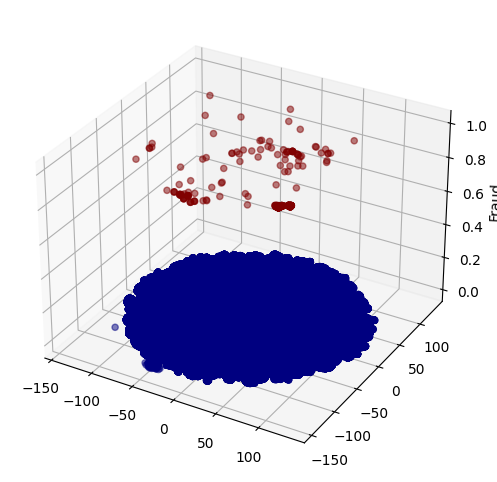

In [27]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection='3d')
ax.scatter(embedded_credit_card_pca[:, 0], embedded_credit_card_pca[:,1], credidcard_fraud_df['Class'], cmap='jet', c=credidcard_fraud_df['Class'], alpha=0.5)
ax.set_zlabel('Fraud')
ax.zaxis.labelpad = 0.7
plt.show()

# Feature Engenering


Text(0.5, 0, 'time of day')

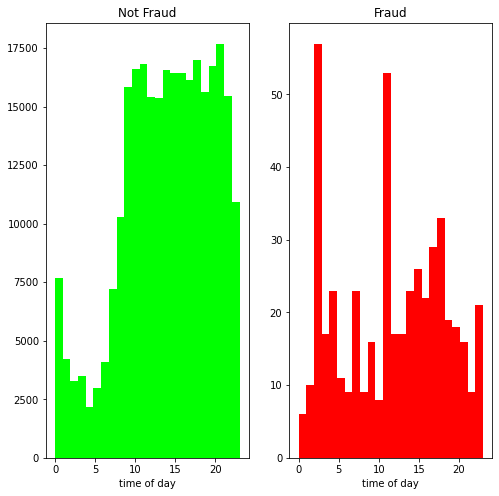

In [4]:
# Create a new feild called 
credidcard_fraud_df["Time-Hour"]=credidcard_fraud_df["Time"]//60//60%24

# Plot dist of transactions based on hour
fig , axs = plt.subplots(1,2 , figsize = (8,8))

axs[0].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==0]['Time-Hour'].values , color = '#00ff00', bins=24)
axs[0].set_title('Not Fraud')
axs[0].set_xlabel('time of day')

axs[1].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==1]['Time-Hour'].values , color = '#ff0000', bins=24)
axs[1].set_title('Fraud')
axs[1].set_xlabel('time of day')


## Visulasation

In [14]:
# Cheack how corrilated the features are with amount

credidcard_fraud_df.corrwith(credidcard_fraud_df['Amount'])

Time        -0.010596
V1          -0.227709
V2          -0.531409
V3          -0.210880
V4           0.098732
V5          -0.386356
V6           0.215981
V7           0.397311
V8          -0.103079
V9          -0.044246
V10         -0.101502
V11          0.000104
V12         -0.009542
V13          0.005293
V14          0.033751
V15         -0.002986
V16         -0.003910
V17          0.007309
V18          0.035650
V19         -0.056151
V20          0.339403
V21          0.105999
V22         -0.064801
V23         -0.112633
V24          0.005146
V25         -0.047837
V26         -0.003208
V27          0.028825
V28          0.010258
Amount       1.000000
Class        0.005632
Time-Hour    0.003249
dtype: float64

In [25]:
pd.plotting.scatter_matrix(credidcard_fraud_df)

array([[<AxesSubplot:xlabel='Time', ylabel='Time'>,
        <AxesSubplot:xlabel='V1', ylabel='Time'>,
        <AxesSubplot:xlabel='V2', ylabel='Time'>, ...,
        <AxesSubplot:xlabel='Amount', ylabel='Time'>,
        <AxesSubplot:xlabel='Class', ylabel='Time'>,
        <AxesSubplot:xlabel='Time-Hour', ylabel='Time'>],
       [<AxesSubplot:xlabel='Time', ylabel='V1'>,
        <AxesSubplot:xlabel='V1', ylabel='V1'>,
        <AxesSubplot:xlabel='V2', ylabel='V1'>, ...,
        <AxesSubplot:xlabel='Amount', ylabel='V1'>,
        <AxesSubplot:xlabel='Class', ylabel='V1'>,
        <AxesSubplot:xlabel='Time-Hour', ylabel='V1'>],
       [<AxesSubplot:xlabel='Time', ylabel='V2'>,
        <AxesSubplot:xlabel='V1', ylabel='V2'>,
        <AxesSubplot:xlabel='V2', ylabel='V2'>, ...,
        <AxesSubplot:xlabel='Amount', ylabel='V2'>,
        <AxesSubplot:xlabel='Class', ylabel='V2'>,
        <AxesSubplot:xlabel='Time-Hour', ylabel='V2'>],
       ...,
       [<AxesSubplot:xlabel='Time', ylabel='Am

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f114e595e50> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f114e595d30> (for post_execute):


KeyboardInterrupt: ignored

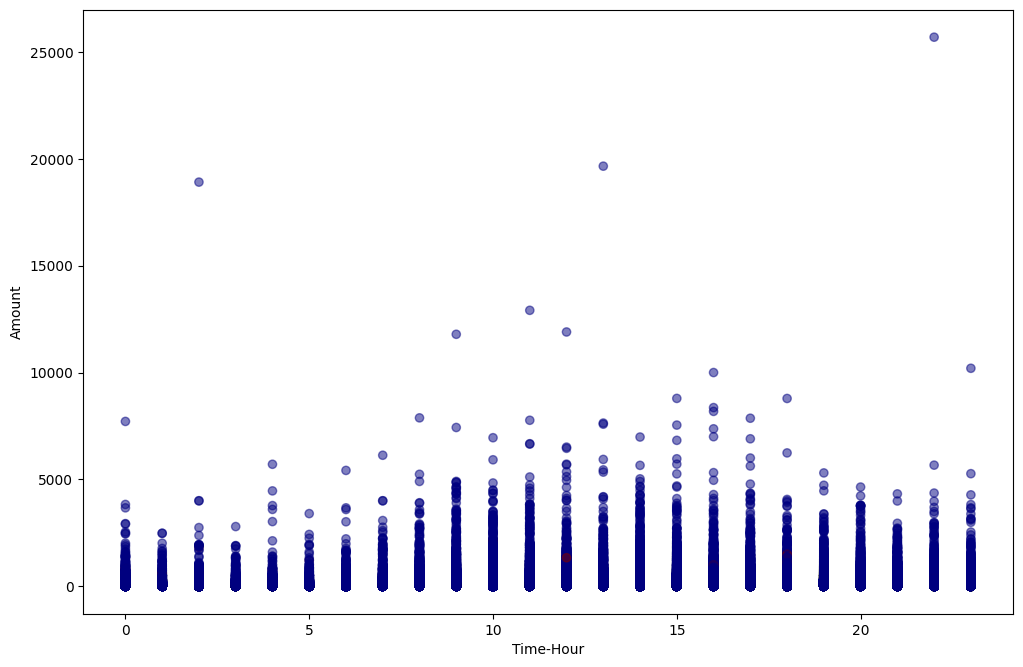

In [23]:
x = credidcard_fraud_df #[credidcard_fraud_df['Class']==0]
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.xlabel("Time-Hour")
plt.ylabel("Amount")
plt.scatter(x = x['Time-Hour'], y = x['Amount'], c=x['Class'], alpha=0.5, cmap = cmap)

plt.show()

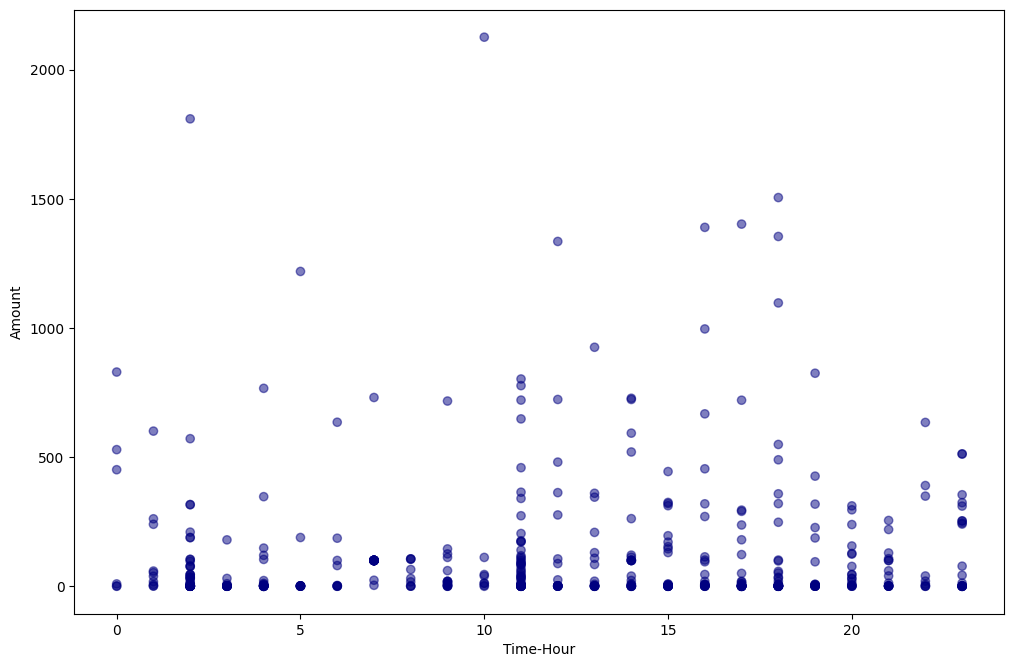

In [24]:
x = credidcard_fraud_df[credidcard_fraud_df['Class']==1]
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.xlabel("Time-Hour")
plt.ylabel("Amount")
plt.scatter(x = x['Time-Hour'], y = x['Amount'], c=x['Class'], alpha=0.5, cmap = cmap)

plt.show()

NameError: name 'X2D' is not defined

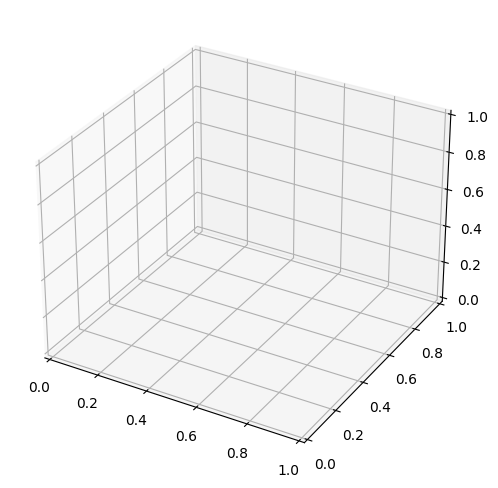

In [19]:
# more visulasation
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_df = X2D
ax.scatter(
    credidcard_fraud_df['Amount'], 
    credidcard_fraud_df['Time-Hour'], 
    credidcard_fraud_df['Class'],
    cmap='jet',
    c=credidcard_fraud_df['Class'], alpha=0.5
)
ax.set_xlabel('Amount')
ax.set_ylabel('Time-Hour')
ax.set_zlabel('Fraud')

# Reduce Dimensionality

In [ ]:
from sklearn.decomposition import PCA

encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28']]

pca = PCA(n_components=2)
pca.fit(encoded_features_df )
X2D = pca.transform(encoded_features_df )



In [ ]:
# now plot
x = X2D[:, 0]
y = X2D[:, 1]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y)

In [ ]:
# Now with the other features
encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28', 'Time-Hour', 'Amount']]

pca = PCA(n_components=2)
pca.fit(encoded_features_df )
X2D = pca.transform(encoded_features_df )

# and plot
x = X2D[:, 0]
y = X2D[:, 1]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y, c=credidcard_fraud_df['Class'], alpha = 0.5)

In [ ]:
# Looks good lets try 3 dim
# Now with the other features
encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28', 'Time-Hour', 'Amount']]

pca = PCA(n_components=3)
pca.fit(encoded_features_df )
X3D = pca.transform(encoded_features_df )

# and plot
x = X3D[:, 0]
y = X3D[:, 1]
c = X3D[:, 2]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y, c=c)

In [ ]:
# more visulasation
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_df = X2D
ax.scatter(
    plot_df[:,0], 
    plot_df[:,1], 
    credidcard_fraud_df['Class'],
    cmap='jet',
    c=credidcard_fraud_df['Class'], alpha=0.5
)
ax.set_xlabel('V29')
ax.set_ylabel('V30')
ax.set_zlabel('Fraud')

# Reduce Dimensionality

In [18]:
from sklearn.decomposition import PCA

encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28']]

pca = PCA(n_components=2)
pca.fit(encoded_features_df )
X2D = pca.transform(encoded_features_df )



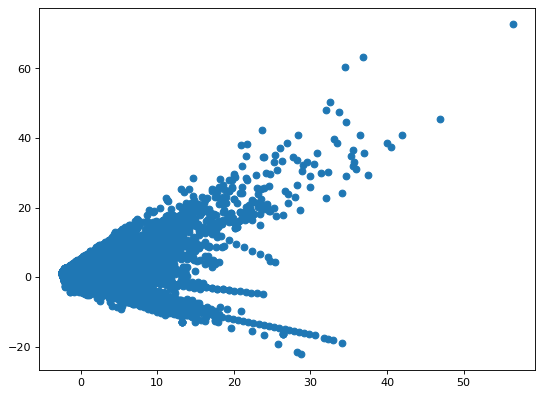

In [19]:
# now plot
x = X2D[:, 0]
y = X2D[:, 1]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y)

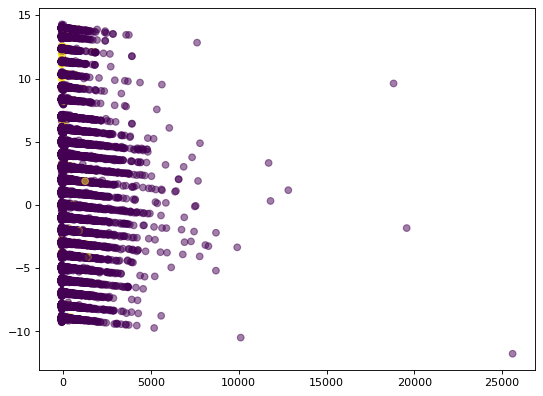

In [24]:
# Now with the other features
encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28', 'Time-Hour', 'Amount']]

pca = PCA(n_components=2)
pca.fit(encoded_features_df )
X2D = pca.transform(encoded_features_df )

# and plot
x = X2D[:, 0]
y = X2D[:, 1]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y, c=credidcard_fraud_df['Class'], alpha = 0.5)

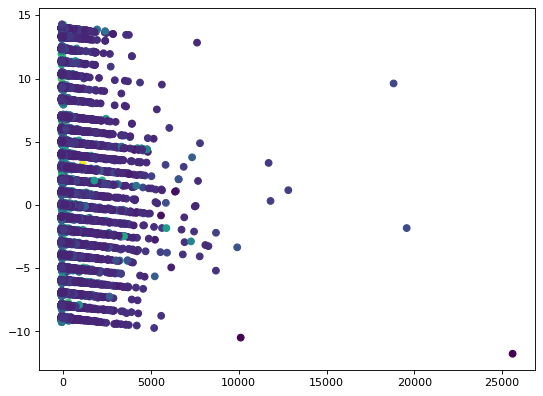

In [21]:
# Looks good lets try 3 dim
# Now with the other features
encoded_features_df = credidcard_fraud_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
      'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
      'V18', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
      'V28', 'Time-Hour', 'Amount']]

pca = PCA(n_components=3)
pca.fit(encoded_features_df )
X3D = pca.transform(encoded_features_df )

# and plot
x = X3D[:, 0]
y = X3D[:, 1]
c = X3D[:, 2]

plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x=x, y=y, c=c)

Text(0.5, 0, 'Fraud')

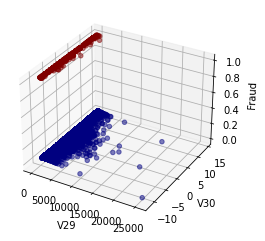

In [26]:
# more visulasation
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_df = X2D
ax.scatter(
    plot_df[:,0], 
    plot_df[:,1], 
    credidcard_fraud_df['Class'],
    cmap='jet',
    c=credidcard_fraud_df['Class'], alpha=0.5
)
ax.set_xlabel('V29')
ax.set_ylabel('V30')
ax.set_zlabel('Fraud')